In [1]:
import midynet
import numpy as np
import matplotlib.pyplot as plt
import multiprocessing as mp
import time
import json

from midynet.util import display
from functools import partial

In [2]:
def SISSusceptibility(x):
    n = x.sum(0)
    return (np.mean(n**2) - np.mean(n)**2) / np.mean(n)

def SISAverage(x):
    return x.mean()

def GlauberSusceptibility(x):
    x[x == 0] = -1
    m = x.mean(0)
    return (np.mean(m**2) - np.mean(np.abs(m))**2) / (np.mean(np.abs(m)))

def GlauberAverage(x):
    y = x * 1
    y[x == 0] = -1
    X = np.mean(y, 0)
    return np.mean(np.abs(X))

def CowanSusceptibility(x):
#     x[x == 0] = -1
#     m = x.mean(-1)
#     return (np.mean(m**2) - np.mean(np.abs(m))**2)
    return x.mean()


susceptiblityFunctions = {
    "glauber": GlauberSusceptibility,
    "ising": GlauberSusceptibility,
    "cowan": CowanSusceptibility,
    "sis": SISSusceptibility
}

averageFunctions = {
    "glauber": GlauberAverage,
    "ising": GlauberAverage,
    "sis": SISAverage,
    "cowan": SISAverage,
}


def collect(cfg, seed=None):
    if seed is not None:
        midynet.utility.seed(seed)
    suscFunc = susceptiblityFunctions[cfg.dynamics.name]
    avgFunc = averageFunctions[cfg.dynamics.name]
    graph = midynet.config.RandomGraphFactory.build(cfg.graph)
    dynamics = midynet.config.DynamicsFactory.build(cfg.dynamics)
    dynamics.set_random_graph(graph.get_wrap())
    dynamics.sample()
    x = np.array(dynamics.get_past_states())
    return suscFunc(x), avgFunc(x)
    
    
def searchThresholds(cfg, paramName, paramMin, paramMax, numPoints=10, delta=1, tol=1e-3, numSamples=10, verbose=1):
    diff = np.inf

    history = {"thresholds":[], "susceptibility":{}, "averages":{}}
    while(diff > tol):
        susceptibility = []
        averages = []
        diff = (paramMax - paramMin) / numPoints
        paramScan = np.linspace(paramMin, paramMax, numPoints)
        if verbose > 0:
            print(f"Scaning params {paramScan}")
            print(f"Current diff: {diff}")
        for p in paramScan:
            cfg.dynamics.set_value(paramName, p)
            if verbose == 1:
                print(p)
            with mp.Pool(4) as pool:
                f = partial(collect, cfg)
                seeds = int(time.time()) + np.arange(numSamples).astype("int")
                out = pool.map(f, seeds)
                s = [ss for ss, aa in out]
                a = [aa for ss, aa in out]
            susceptibility.append(np.mean(s))
            averages.append(np.mean(a))
    
        for s, a, p in zip(susceptibility, averages, paramScan):
            if p in history["susceptibility"]:
                history["susceptibility"][p].append(s)
            else:
                history["susceptibility"][p] = [s]
            if p in history["averages"]:
                history["averages"][p].append(a)
            else:
                history["averages"][p] = [a]
                
#         plt.plot(paramScan, susceptibility)
#         plt.show()

        maxIndex = np.argmax(susceptibility)
        paramMin = paramScan[maxIndex] - delta * diff
        paramMax = paramScan[maxIndex] + delta * diff
        history["thresholds"].append(paramScan[maxIndex])
        if verbose > 0:
            print(f"Current history: {history}")
    return history


def moving_average(a, n=3) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return (ret[n - 1:] / n)[::n]

def collectCowan(cfg, seed=None):
    if seed is not None:
        midynet.utility.seed(seed)
    graph = midynet.config.RandomGraphFactory.build(cfg.graph)
    dynamics = midynet.config.DynamicsFactory.build(cfg.dynamics)
    dynamics.set_random_graph(graph.get_wrap())

    dynamics.sample()
    x = np.array(dynamics.get_past_states())
    return np.mean(x)

def searchCowanThresholds(cfg, paramMin, paramMax, *, delta=2, tol=0.01, numSamples=10, numPoints=10, numProcs=4, verbose=0, parallel=True):
    diff = np.inf
    history = {"thresholds":[], "susceptibility": {}, "averages": {}}
    while(diff > tol):
        avgx = []
        susceptibility = []
        paramScan = np.linspace(paramMin, paramMax, numPoints)
        diff = (paramMax - paramMin) / numPoints
        
        if verbose > 0:
            print(f"Scanning params: {paramScan}")
            print(f"Current diff: {diff}")
        for p in paramScan:
            cfg.dynamics.set_coupling(p)
            f = partial(collectCowan, cfg)
            seeds = int(time.time()) + np.arange(numSamples).astype("int")
            if parallel:
                with mp.Pool(numProcs) as pool:
                    x = pool.map(f, seeds)
            else:
                x = [f(s) for s in seeds]
            x = np.array(x)
            if np.any(x < 0.05):
                x = x[x < 0.05]
            s = np.std(x) / np.mean(x)
            if verbose == 1:
                print(p, s, np.mean(x))
            susceptibility.append(s)
            avgx.append(np.mean(x))
        avgx = np.array(avgx)
    
        xm = avgx[:-1]
        xp = avgx[1:]
        
        
        gap = np.abs(avgx[1:] - avgx[:-1]) / diff
        gap = np.append(gap, 0)
        maxGapIndex = np.argmax(gap)
#         maxGapIndex = np.argmax(susceptibility)
        paramMin = paramScan[maxGapIndex] - delta * diff
        paramMax = paramScan[maxGapIndex] + delta * diff
        if verbose == 1:
            ax = plt.gca()
            ax.plot(paramScan, avgx, "ro-")
            axx = ax.twinx()
            axx.plot(paramScan, susceptibility, "bs-")
            ax.axvspan(paramMin, paramMax, color="grey", alpha=0.3)
            plt.show()
        for p, x, g in zip(paramScan, avgx, susceptibility):
            if p in history["susceptibility"]:
                history["susceptibility"][p].append(g)
            else:
                history["susceptibility"][p] = [g]
                
            if p in history["averages"]:
                history["averages"][p].append(x)
            else:
                history["averages"][p] = [x]
        history["thresholds"].append(paramScan[maxGapIndex])
        if verbose > 0:
            print(f"Current history: {history}")
    return history

def plotThresholdSearch(ax, history, paramName=f"Coupling"):
    x = []; y = []; z = []

    for k in history["susceptibility"].keys():
        x.append(float(k))
        y.append(np.mean(history["susceptibility"][k]))
        z.append(np.mean(history["averages"][k]))
    indices = np.argsort(x)
    x = np.array(x)[indices]
    y = np.array(y)[indices]
    z = np.array(z)[indices]
    axx = ax.twinx()
    print(x)
    
    ax.plot(x, y, "o-", color=display.med_colors["blue"])
    axx.plot(x, z, "s-", color=display.med_colors["red"])
    if "thresholds" in history:
        t = history["thresholds"]
        for tt in t[:-1]:
            ax.axvline(tt, linestyle="--", color="grey")
        ax.axvline(t[-1], linestyle="--", color="k", linewidth=2)
    ax.set_xlabel(paramName)
    ax.set_ylabel(r"Susceptibility")
    ax.set_ylim([y.min(), y.max() * 1.1])
#     ax.set_xlim([x.min(), x.max()])
    axx.set_ylabel(r"Average state")
    axx.set_ylim([z.min(), z.max() * 1.1])
    return ax

def showThresholdSearch(history, paramName=f"Coupling"):
    plotThresholdSearch(plt.gca(), history, paramName=paramName)


In [3]:
# histories = {}

with open("thresholds.json", "r") as f:
    histories = json.load(f)


Scaning params [0.         0.08333333 0.16666667 0.25       0.33333333 0.41666667
 0.5        0.58333333 0.66666667 0.75      ]
Current diff: 0.075
Current history: {'thresholds': [0.25], 'susceptibility': {0.0: [0.9955373783557905], 0.08333333333333333: [1.2020864311358233], 0.16666666666666666: [2.063874257857194], 0.25: [6.583632131986828], 0.3333333333333333: [3.5297822928330937], 0.41666666666666663: [2.0086455817032447], 0.5: [1.4625390027292056], 0.5833333333333333: [1.3004705102671343], 0.6666666666666666: [1.113074344531979], 0.75: [1.0108514288683372]}, 'averages': {0.0: [0.001999233333333333], 0.08333333333333333: [0.0024800499999999997], 0.16666666666666666: [0.003816441666666666], 0.25: [0.012597283333333334], 0.3333333333333333: [0.07277571666666666], 0.41666666666666663: [0.1335733], 0.5: [0.18320404166666668], 0.5833333333333333: [0.2237907], 0.6666666666666666: [0.25884739999999995], 0.75: [0.28759534999999997]}}
Scaning params [0.175      0.19166667 0.20833333 0.225  

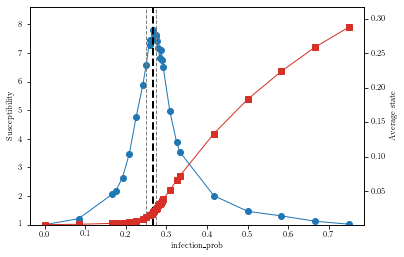

In [7]:
config = midynet.config.ExperimentConfig.default("susceptiblity", "sis", "nbinom_cm")

config.graph.set_value("size", 1000)
config.graph.edge_count.set_value("state", 2500)
config.graph.set_value("heterogeneity", 1)

config.dynamics.set_value("num_steps", 10000)
config.dynamics.set_value("recovery_prob", 0.5)
config.dynamics.set_value("auto_activation_prob", 0.001)
config.dynamics.set_value("num_active", 1)

histories["sis"] = searchThresholds(config, "infection_prob", 0, 0.75, tol=0.01, numSamples=12, verbose=2)
showThresholdSearch(histories["sis"], f"infection_prob")

In [5]:
res_sis = {'thresholds': [0.25, 0.275, 0.26666666666666666], 'susceptibility': {0.0: [0.9955373783557905], 0.08333333333333333: [1.2020864311358233], 0.16666666666666666: [2.063874257857194], 0.25: [6.583632131986828], 0.3333333333333333: [3.5297822928330937], 0.41666666666666663: [2.0086455817032447], 0.5: [1.4625390027292056], 0.5833333333333333: [1.3004705102671343], 0.6666666666666666: [1.113074344531979], 0.75: [1.0108514288683372], 0.175: [2.176133616221095], 0.19166666666666665: [2.641874755835327], 0.20833333333333331: [3.4725097886585394], 0.225: [4.748221149054636], 0.24166666666666667: [5.879180722593943], 0.2583333333333333: [7.439774562050148], 0.275: [7.624003786172359], 0.2916666666666667: [6.521099670719153], 0.30833333333333335: [4.9619555360780785], 0.325: [3.8705842981009972], 0.26: [7.263525844273905], 0.26333333333333336: [7.471664143010746], 0.26666666666666666: [7.82130858945034], 0.27: [7.666772666861835], 0.2733333333333334: [7.59933254798132], 0.27666666666666667: [7.406802862571762], 0.28: [7.16458612072888], 0.2833333333333334: [6.8311702925274025], 0.2866666666666667: [7.093578889343287], 0.29000000000000004: [6.751572957477215]}, 'averages': {0.0: [0.001999233333333333], 0.08333333333333333: [0.0024800499999999997], 0.16666666666666666: [0.003816441666666666], 0.25: [0.012597283333333334], 0.3333333333333333: [0.07277571666666666], 0.41666666666666663: [0.1335733], 0.5: [0.18320404166666668], 0.5833333333333333: [0.2237907], 0.6666666666666666: [0.25884739999999995], 0.75: [0.28759534999999997], 0.175: [0.004018566666666667], 0.19166666666666665: [0.004640883333333333], 0.20833333333333331: [0.005712608333333333], 0.225: [0.007553433333333332], 0.24166666666666667: [0.010120633333333332], 0.2583333333333333: [0.015431383333333333], 0.275: [0.024590683333333332], 0.2916666666666667: [0.03842120833333333], 0.30833333333333335: [0.051866108333333334], 0.325: [0.06605838333333332], 0.26: [0.016387083333333333], 0.26333333333333336: [0.017956125], 0.26666666666666666: [0.020014450000000003], 0.27: [0.021100983333333333], 0.2733333333333334: [0.024431316666666664], 0.27666666666666667: [0.026103183333333335], 0.28: [0.029965308333333333], 0.2833333333333334: [0.03216778333333333], 0.2866666666666667: [0.03372922500000001], 0.29000000000000004: [0.03639303333333333]}}

Scaning params [0.         0.11111111 0.22222222 0.33333333 0.44444444 0.55555556
 0.66666667 0.77777778 0.88888889 1.        ]
Current diff: 0.1
Current history: {'thresholds': [0.5555555555555556], 'susceptibility': {0.0: [0.014449722322674293], 0.1111111111111111: [0.014565656381163791], 0.2222222222222222: [0.015156336932378571], 0.3333333333333333: [0.016584748477753358], 0.4444444444444444: [0.02029038437788531], 0.5555555555555556: [0.03079511636536103], 0.6666666666666666: [0.006586118133298808], 0.7777777777777777: [0.003482263414413], 0.8888888888888888: [0.0024963061125577463], 1.0: [0.002068575508543335]}, 'averages': {0.0: [0.02526489583333334], 0.1111111111111111: [0.0255283125], 0.2222222222222222: [0.0265943875], 0.3333333333333333: [0.029044716666666675], 0.4444444444444444: [0.035890579166666665], 0.5555555555555556: [0.07801747083333334], 0.6666666666666666: [0.2376864916666667], 0.7777777777777777: [0.33171186249999995], 0.8888888888888888: [0.4000762166666667], 1.0

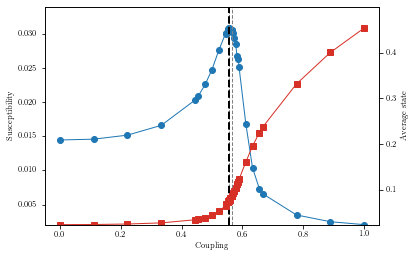

In [8]:
config = midynet.config.ExperimentConfig.default("susceptiblity", "ising", "nbinom_cm")

config.graph.set_value("size", 1000)
config.graph.edge_count.set_value("state", 2500)
config.graph.set_value("heterogeneity", 1)

config.dynamics.set_value("num_steps", 10000)

histories["ising"] = searchThresholds(config, "coupling", 0, 1, delta=1, tol=0.001, numSamples=48, verbose=2)

showThresholdSearch(histories["ising"], f"Coupling")


In [6]:
res_glauber = {'thresholds': [0.5555555555555556, 0.5666666666666667, 0.5555555555555556, 0.5568888888888889], 'susceptibility': {0.0: [0.014449722322674293], 0.1111111111111111: [0.014565656381163791], 0.2222222222222222: [0.015156336932378571], 0.3333333333333333: [0.016584748477753358], 0.4444444444444444: [0.02029038437788531], 0.5555555555555556: [0.03079511636536103, 0.03071443646986749], 0.6666666666666666: [0.006586118133298808], 0.7777777777777777: [0.003482263414413], 0.8888888888888888: [0.0024963061125577463], 1.0: [0.002068575508543335], 0.4555555555555556: [0.02092285735864378], 0.4777777777777778: [0.02257729370408988], 0.5: [0.02474425549966126], 0.5222222222222223: [0.027542449694049825], 0.5444444444444445: [0.030000718467140624], 0.5666666666666667: [0.030539145573178588], 0.5888888888888889: [0.025115703255303785], 0.6111111111111112: [0.016851309085948212], 0.6333333333333333: [0.010359160804689476], 0.6555555555555556: [0.0073446065811605945], 0.5466666666666666: [0.03008297275102211], 0.5511111111111111: [0.03029330411578471], 0.5599999999999999: [0.030402377984110798], 0.5644444444444444: [0.030566224822514285], 0.5688888888888889: [0.030090765997610184], 0.5733333333333334: [0.029381457833669022], 0.5777777777777777: [0.028537873516958617], 0.5822222222222222: [0.026738045924212833], 0.5866666666666667: [0.02627589606405217], 0.5515555555555556: [0.030563263392610906], 0.5524444444444445: [0.03069145968885559], 0.5533333333333333: [0.030684624599165017], 0.5542222222222223: [0.030602940264985817], 0.5551111111111111: [0.03051057900396738], 0.556: [0.030660206771688323], 0.5568888888888889: [0.03078797616532639], 0.5577777777777778: [0.0304403024472357], 0.5586666666666666: [0.030565010261505644], 0.5595555555555556: [0.030538660678415142]}, 'averages': {0.0: [0.02526489583333334], 0.1111111111111111: [0.0255283125], 0.2222222222222222: [0.0265943875], 0.3333333333333333: [0.029044716666666675], 0.4444444444444444: [0.035890579166666665], 0.5555555555555556: [0.07801747083333334, 0.07680814166666668], 0.6666666666666666: [0.2376864916666667], 0.7777777777777777: [0.33171186249999995], 0.8888888888888888: [0.4000762166666667], 1.0: [0.4533435625], 0.4555555555555556: [0.037378116666666676], 0.4777777777777778: [0.04069853750000001], 0.5: [0.045768170833333344], 0.5222222222222223: [0.053877683333333336], 0.5444444444444445: [0.06651922083333334], 0.5666666666666667: [0.0883360875], 0.5888888888888889: [0.12388170833333334], 0.6111111111111112: [0.16141589166666667], 0.6333333333333333: [0.19636379166666665], 0.6555555555555556: [0.22523742083333334], 0.5466666666666666: [0.07047285833333333], 0.5511111111111111: [0.07363416666666667], 0.5599999999999999: [0.08276594999999999], 0.5644444444444444: [0.08749068333333333], 0.5688888888888889: [0.09336627500000001], 0.5733333333333334: [0.09837585000000003], 0.5777777777777777: [0.1047917375], 0.5822222222222222: [0.114523225], 0.5866666666666667: [0.11879225], 0.5515555555555556: [0.07374148333333334], 0.5524444444444445: [0.0735133375], 0.5533333333333333: [0.07440895416666667], 0.5542222222222223: [0.07591245833333334], 0.5551111111111111: [0.07712272916666668], 0.556: [0.07631860000000001], 0.5568888888888889: [0.07903951666666666], 0.5577777777777778: [0.07977603750000001], 0.5586666666666666: [0.08132870416666667], 0.5595555555555556: [0.08190098750000001]}}

Scanning params: [1.         1.22222222 1.44444444 1.66666667 1.88888889 2.11111111
 2.33333333 2.55555556 2.77777778 3.        ]
Current diff: 0.2
1.0 0.059802282845908064 0.002291333333333333
1.2222222222222223 0.07446612568759482 0.003843916666666667
1.4444444444444444 0.024341866505123856 0.18628183333333334
1.6666666666666665 0.006991840243193676 0.25260325000000006
1.8888888888888888 0.008178240433084315 0.29566924999999994
2.111111111111111 0.006356762036091629 0.32880558333333326
2.333333333333333 0.005704194169926221 0.3563439166666667
2.5555555555555554 0.003952090295917306 0.381438
2.7777777777777777 0.004021597994819511 0.40207583333333335
3.0 0.005772468106077235 0.41712108333333325


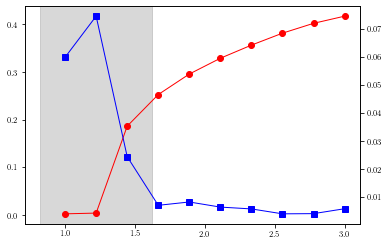

Current history: {'thresholds': [1.2222222222222223], 'susceptibility': {1.0: [0.059802282845908064], 1.2222222222222223: [0.07446612568759482], 1.4444444444444444: [0.024341866505123856], 1.6666666666666665: [0.006991840243193676], 1.8888888888888888: [0.008178240433084315], 2.111111111111111: [0.006356762036091629], 2.333333333333333: [0.005704194169926221], 2.5555555555555554: [0.003952090295917306], 2.7777777777777777: [0.004021597994819511], 3.0: [0.005772468106077235]}, 'averages': {1.0: [0.002291333333333333], 1.2222222222222223: [0.003843916666666667], 1.4444444444444444: [0.18628183333333334], 1.6666666666666665: [0.25260325000000006], 1.8888888888888888: [0.29566924999999994], 2.111111111111111: [0.32880558333333326], 2.333333333333333: [0.3563439166666667], 2.5555555555555554: [0.381438], 2.7777777777777777: [0.40207583333333335], 3.0: [0.41712108333333325]}}
Scanning params: [0.82222222 0.91111111 1.         1.08888889 1.17777778 1.26666667
 1.35555556 1.44444444 1.53333333

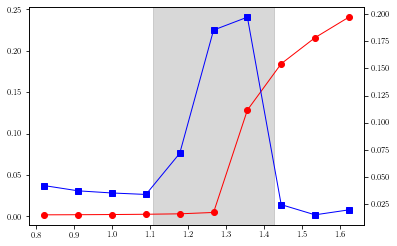

Current history: {'thresholds': [1.2222222222222223, 1.2666666666666666], 'susceptibility': {1.0: [0.059802282845908064, 0.035317890356326626], 1.2222222222222223: [0.07446612568759482], 1.4444444444444444: [0.024341866505123856, 0.024594782032420666], 1.6666666666666665: [0.006991840243193676], 1.8888888888888888: [0.008178240433084315], 2.111111111111111: [0.006356762036091629], 2.333333333333333: [0.005704194169926221], 2.5555555555555554: [0.003952090295917306], 2.7777777777777777: [0.004021597994819511], 3.0: [0.005772468106077235], 0.8222222222222223: [0.042078846417387045], 0.9111111111111112: [0.03728258919376311], 1.088888888888889: [0.033965033624477066], 1.1777777777777778: [0.07183237103587048], 1.2666666666666666: [0.18526708921782817], 1.3555555555555556: [0.19714253992786024], 1.5333333333333332: [0.015206484320891035], 1.6222222222222222: [0.019772536910977058]}, 'averages': {1.0: [0.002291333333333333, 0.002275], 1.2222222222222223: [0.003843916666666667], 1.4444444444

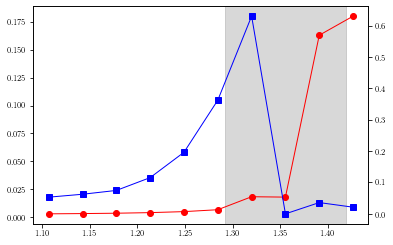

Current history: {'thresholds': [1.2222222222222223, 1.2666666666666666, 1.3555555555555554], 'susceptibility': {1.0: [0.059802282845908064, 0.035317890356326626], 1.2222222222222223: [0.07446612568759482], 1.4444444444444444: [0.024341866505123856, 0.024594782032420666], 1.6666666666666665: [0.006991840243193676], 1.8888888888888888: [0.008178240433084315], 2.111111111111111: [0.006356762036091629], 2.333333333333333: [0.005704194169926221], 2.5555555555555554: [0.003952090295917306], 2.7777777777777777: [0.004021597994819511], 3.0: [0.005772468106077235], 0.8222222222222223: [0.042078846417387045], 0.9111111111111112: [0.03728258919376311], 1.088888888888889: [0.033965033624477066], 1.1777777777777778: [0.07183237103587048, 0.0746162122852326], 1.2666666666666666: [0.18526708921782817], 1.3555555555555556: [0.19714253992786024], 1.5333333333333332: [0.015206484320891035], 1.6222222222222222: [0.019772536910977058], 1.1066666666666667: [0.05315274719100304], 1.1422222222222222: [0.062

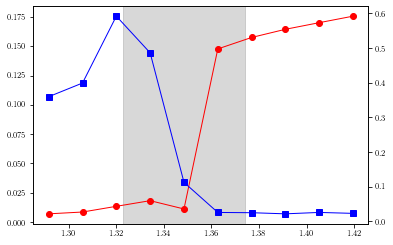

Current history: {'thresholds': [1.2222222222222223, 1.2666666666666666, 1.3555555555555554, 1.3484444444444443], 'susceptibility': {1.0: [0.059802282845908064, 0.035317890356326626], 1.2222222222222223: [0.07446612568759482], 1.4444444444444444: [0.024341866505123856, 0.024594782032420666], 1.6666666666666665: [0.006991840243193676], 1.8888888888888888: [0.008178240433084315], 2.111111111111111: [0.006356762036091629], 2.333333333333333: [0.005704194169926221], 2.5555555555555554: [0.003952090295917306], 2.7777777777777777: [0.004021597994819511], 3.0: [0.005772468106077235], 0.8222222222222223: [0.042078846417387045], 0.9111111111111112: [0.03728258919376311], 1.088888888888889: [0.033965033624477066], 1.1777777777777778: [0.07183237103587048, 0.0746162122852326], 1.2666666666666666: [0.18526708921782817], 1.3555555555555556: [0.19714253992786024], 1.5333333333333332: [0.015206484320891035], 1.6222222222222222: [0.019772536910977058], 1.1066666666666667: [0.05315274719100304], 1.1422

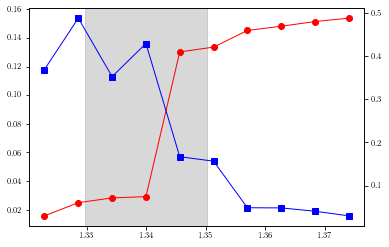

Current history: {'thresholds': [1.2222222222222223, 1.2666666666666666, 1.3555555555555554, 1.3484444444444443, 1.339911111111111], 'susceptibility': {1.0: [0.059802282845908064, 0.035317890356326626], 1.2222222222222223: [0.07446612568759482], 1.4444444444444444: [0.024341866505123856, 0.024594782032420666], 1.6666666666666665: [0.006991840243193676], 1.8888888888888888: [0.008178240433084315], 2.111111111111111: [0.006356762036091629], 2.333333333333333: [0.005704194169926221], 2.5555555555555554: [0.003952090295917306], 2.7777777777777777: [0.004021597994819511], 3.0: [0.005772468106077235], 0.8222222222222223: [0.042078846417387045], 0.9111111111111112: [0.03728258919376311], 1.088888888888889: [0.033965033624477066], 1.1777777777777778: [0.07183237103587048, 0.0746162122852326], 1.2666666666666666: [0.18526708921782817], 1.3555555555555556: [0.19714253992786024], 1.5333333333333332: [0.015206484320891035], 1.6222222222222222: [0.019772536910977058], 1.1066666666666667: [0.0531527

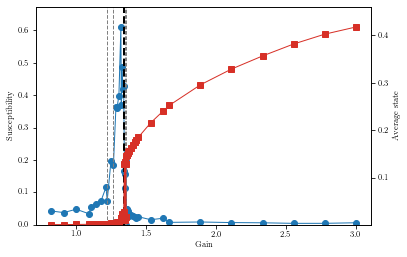

In [4]:
config = midynet.config.ExperimentConfig.default("susceptiblity", "cowan_backward", "nbinom_cm")

N = 1000
avgk = 5
config.graph.set_value("size", N)
config.graph.edge_count.set_value("state", avgk * N / 2)
config.graph.set_value("heterogeneity", 1)

config.dynamics.set_value("num_steps", 1000)
    
histories["cowan_backward"] = searchCowanThresholds(config, 1, 3, delta=2, tol=0.01, numSamples=12, numPoints=10, verbose=1)
showThresholdSearch(histories["cowan_backward"], f"Gain")


Scanning params: [1.         1.22222222 1.44444444 1.66666667 1.88888889 2.11111111
 2.33333333 2.55555556 2.77777778 3.        ]
Current diff: 0.2
1.0 0.06582342816486178 0.0006681041666666667
1.2222222222222223 0.05846771554222465 0.0006765416666666668
1.4444444444444444 0.05886050084499977 0.0006866458333333334
1.6666666666666665 0.05636077201783856 0.0007036041666666666
1.8888888888888888 0.07597854964203571 0.0007289347826086956
2.111111111111111 2.767012986132994 0.003951926829268293
2.333333333333333 2.3482120646154567 0.0051069999999999996
2.5555555555555554 0.13273392178391602 0.32785991666666664
2.7777777777777777 0.048273284245777835 0.37676012499999995
3.0 0.02796399647246088 0.4032305833333332


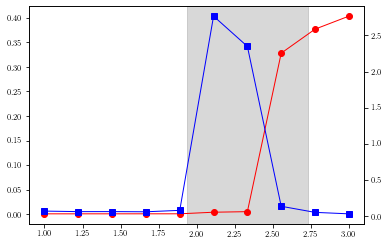

Current history: {'thresholds': [2.333333333333333], 'susceptibility': {1.0: [0.06582342816486178], 1.2222222222222223: [0.05846771554222465], 1.4444444444444444: [0.05886050084499977], 1.6666666666666665: [0.05636077201783856], 1.8888888888888888: [0.07597854964203571], 2.111111111111111: [2.767012986132994], 2.333333333333333: [2.3482120646154567], 2.5555555555555554: [0.13273392178391602], 2.7777777777777777: [0.048273284245777835], 3.0: [0.02796399647246088]}, 'averages': {1.0: [0.0006681041666666667], 1.2222222222222223: [0.0006765416666666668], 1.4444444444444444: [0.0006866458333333334], 1.6666666666666665: [0.0007036041666666666], 1.8888888888888888: [0.0007289347826086956], 2.111111111111111: [0.003951926829268293], 2.333333333333333: [0.0051069999999999996], 2.5555555555555554: [0.32785991666666664], 2.7777777777777777: [0.37676012499999995], 3.0: [0.4032305833333332]}}
Scanning params: [1.93333333 2.02222222 2.11111111 2.2        2.28888889 2.37777778
 2.46666667 2.55555556 

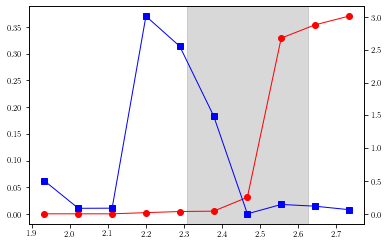

Current history: {'thresholds': [2.333333333333333, 2.4666666666666663], 'susceptibility': {1.0: [0.06582342816486178], 1.2222222222222223: [0.05846771554222465], 1.4444444444444444: [0.05886050084499977], 1.6666666666666665: [0.05636077201783856], 1.8888888888888888: [0.07597854964203571], 2.111111111111111: [2.767012986132994], 2.333333333333333: [2.3482120646154567], 2.5555555555555554: [0.13273392178391602, 0.1429868375465543], 2.7777777777777777: [0.048273284245777835], 3.0: [0.02796399647246088], 1.9333333333333331: [0.5019707355715289], 2.022222222222222: [0.08430412987908625], 2.1111111111111107: [0.08605426655118496], 2.1999999999999997: [3.01031197023769], 2.2888888888888888: [2.551484730488011], 2.3777777777777773: [1.4936778340737853], 2.4666666666666663: [0.0], 2.644444444444444: [0.11634734159765853], 2.733333333333333: [0.06366306586357612]}, 'averages': {1.0: [0.0006681041666666667], 1.2222222222222223: [0.0006765416666666668], 1.4444444444444444: [0.0006866458333333334

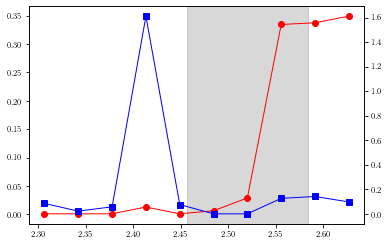

Current history: {'thresholds': [2.333333333333333, 2.4666666666666663, 2.5199999999999996], 'susceptibility': {1.0: [0.06582342816486178], 1.2222222222222223: [0.05846771554222465], 1.4444444444444444: [0.05886050084499977], 1.6666666666666665: [0.05636077201783856], 1.8888888888888888: [0.07597854964203571], 2.111111111111111: [2.767012986132994], 2.333333333333333: [2.3482120646154567], 2.5555555555555554: [0.13273392178391602, 0.1429868375465543, 0.12636162902245188], 2.7777777777777777: [0.048273284245777835], 3.0: [0.02796399647246088], 1.9333333333333331: [0.5019707355715289], 2.022222222222222: [0.08430412987908625], 2.1111111111111107: [0.08605426655118496], 2.1999999999999997: [3.01031197023769], 2.2888888888888888: [2.551484730488011], 2.3777777777777773: [1.4936778340737853, 0.05725836179260399], 2.4666666666666663: [0.0], 2.644444444444444: [0.11634734159765853], 2.733333333333333: [0.06366306586357612], 2.306666666666666: [0.08483145251179022], 2.342222222222222: [0.02203

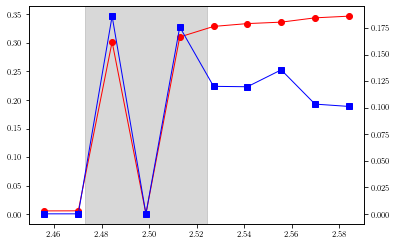

Current history: {'thresholds': [2.333333333333333, 2.4666666666666663, 2.5199999999999996, 2.4986666666666664], 'susceptibility': {1.0: [0.06582342816486178], 1.2222222222222223: [0.05846771554222465], 1.4444444444444444: [0.05886050084499977], 1.6666666666666665: [0.05636077201783856], 1.8888888888888888: [0.07597854964203571], 2.111111111111111: [2.767012986132994], 2.333333333333333: [2.3482120646154567], 2.5555555555555554: [0.13273392178391602, 0.1429868375465543, 0.12636162902245188, 0.13562615249096274], 2.7777777777777777: [0.048273284245777835], 3.0: [0.02796399647246088], 1.9333333333333331: [0.5019707355715289], 2.022222222222222: [0.08430412987908625], 2.1111111111111107: [0.08605426655118496], 2.1999999999999997: [3.01031197023769], 2.2888888888888888: [2.551484730488011], 2.3777777777777773: [1.4936778340737853, 0.05725836179260399], 2.4666666666666663: [0.0], 2.644444444444444: [0.11634734159765853], 2.733333333333333: [0.06366306586357612], 2.306666666666666: [0.084831

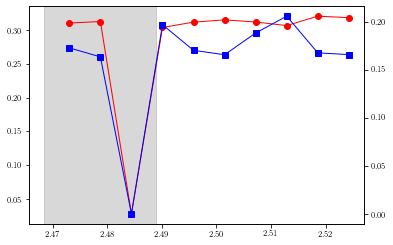

Current history: {'thresholds': [2.333333333333333, 2.4666666666666663, 2.5199999999999996, 2.4986666666666664, 2.4787555555555554], 'susceptibility': {1.0: [0.06582342816486178], 1.2222222222222223: [0.05846771554222465], 1.4444444444444444: [0.05886050084499977], 1.6666666666666665: [0.05636077201783856], 1.8888888888888888: [0.07597854964203571], 2.111111111111111: [2.767012986132994], 2.333333333333333: [2.3482120646154567], 2.5555555555555554: [0.13273392178391602, 0.1429868375465543, 0.12636162902245188, 0.13562615249096274], 2.7777777777777777: [0.048273284245777835], 3.0: [0.02796399647246088], 1.9333333333333331: [0.5019707355715289], 2.022222222222222: [0.08430412987908625], 2.1111111111111107: [0.08605426655118496], 2.1999999999999997: [3.01031197023769], 2.2888888888888888: [2.551484730488011], 2.3777777777777773: [1.4936778340737853, 0.05725836179260399], 2.4666666666666663: [0.0], 2.644444444444444: [0.11634734159765853], 2.733333333333333: [0.06366306586357612], 2.306666

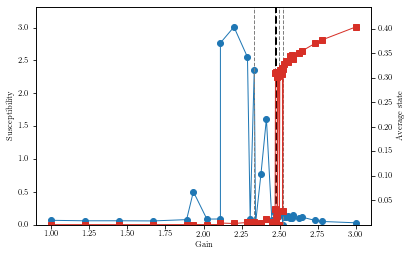

In [7]:
config = midynet.config.ExperimentConfig.default("susceptiblity", "cowan_forward", "nbinom_cm")

N = 1000
avgk = 5
config.graph.set_value("size", N)
config.graph.edge_count.set_value("state", avgk * N / 2)
config.graph.set_value("heterogeneity", 1)

config.dynamics.set_value("num_steps", 1000)
config.dynamics.set_value("num_active", 1)
    
histories["cowan_forward"] = searchCowanThresholds(config, 1, 3, delta=2, tol=0.01, numSamples=48, numPoints=10, verbose=1)
showThresholdSearch(histories["cowan_forward"], f"Gain")



In [11]:
import json

with open("thresholds.json", "w") as f:
    json.dump(histories, f )
    

[0.         0.11111111 0.22222222 0.33333333 0.44444444 0.45555556
 0.47777778 0.5        0.52222222 0.54444444 0.54666667 0.55111111
 0.55155556 0.55244444 0.55333333 0.55422222 0.55511111 0.55555556
 0.556      0.55688889 0.55777778 0.55866667 0.55955556 0.56
 0.56444444 0.56666667 0.56888889 0.57333333 0.57777778 0.58222222
 0.58666667 0.58888889 0.61111111 0.63333333 0.65555556 0.66666667
 0.77777778 0.88888889 1.        ]
[0.         0.08333333 0.16666667 0.175      0.19166667 0.20833333
 0.225      0.24166667 0.25       0.25833333 0.26       0.26333333
 0.26666667 0.27       0.27333333 0.275      0.27666667 0.28
 0.28333333 0.28666667 0.29       0.29166667 0.30833333 0.325
 0.33333333 0.41666667 0.5        0.58333333 0.66666667 0.75      ]
[0.82222222 0.91111111 1.         1.08888889 1.10666667 1.14222222
 1.17777778 1.21333333 1.22222222 1.24888889 1.26666667 1.28444444
 1.29155556 1.30577778 1.32       1.32284444 1.32853333 1.33422222
 1.33991111 1.3456     1.34844444 1.3512888

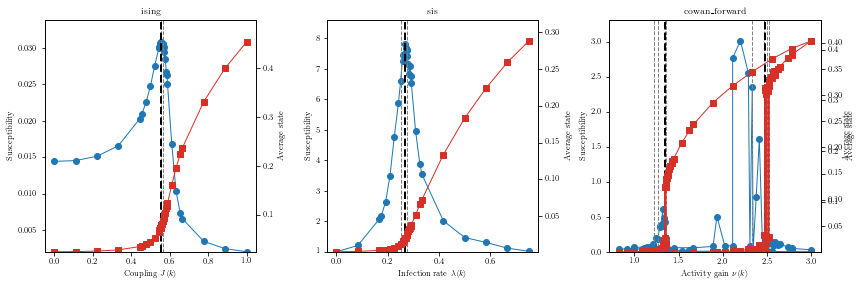

In [8]:
fig, ax = plt.subplots(1, 3, figsize=(12, 4))

xlabels = {
    "ising": r"Coupling $J\langle k \rangle$",
    "sis": r"Infection rate $\lambda \langle k \rangle$",
    "cowan_backward": r"Activity gain $\nu\langle k \rangle$",
    "cowan_forward": r"Activity gain $\nu\langle k \rangle$"
}

for i, k in enumerate(xlabels.keys()):
    if k[:5] == "cowan":
        i = 2
    plotThresholdSearch(ax[i], histories[k], xlabels[k])
    ax[i].set_title(k)
    x = list(histories[k].keys())
#     ax[i].set_xlim([min(x), max(x)])

fig.tight_layout()
plt.show()

In [4]:
res_cowanbackward = {'thresholds': [1.2222222222222223, 1.2666666666666666, 1.3555555555555554, 1.3484444444444443, 1.339911111111111], 'susceptibility': {1.0: [0.059802282845908064, 0.035317890356326626], 1.2222222222222223: [0.07446612568759482], 1.4444444444444444: [0.024341866505123856, 0.024594782032420666], 1.6666666666666665: [0.006991840243193676], 1.8888888888888888: [0.008178240433084315], 2.111111111111111: [0.006356762036091629], 2.333333333333333: [0.005704194169926221], 2.5555555555555554: [0.003952090295917306], 2.7777777777777777: [0.004021597994819511], 3.0: [0.005772468106077235], 0.8222222222222223: [0.042078846417387045], 0.9111111111111112: [0.03728258919376311], 1.088888888888889: [0.033965033624477066], 1.1777777777777778: [0.07183237103587048, 0.0746162122852326], 1.2666666666666666: [0.18526708921782817], 1.3555555555555556: [0.19714253992786024], 1.5333333333333332: [0.015206484320891035], 1.6222222222222222: [0.019772536910977058], 1.1066666666666667: [0.05315274719100304], 1.1422222222222222: [0.06245325297844678], 1.2133333333333334: [0.11548488112435751], 1.2488888888888887: [0.19625866955680793], 1.2844444444444443: [0.3624247096521774], 1.3199999999999998: [0.6303610153862057, 0.5912941187587629], 1.3555555555555554: [0.0], 1.391111111111111: [0.035885605107877354, 0.02203508518179466], 1.4266666666666665: [0.02120751291692739], 1.2915555555555553: [0.3593439841923095], 1.3057777777777775: [0.39872673393841507], 1.334222222222222: [0.4855843633810375, 0.35217742878229075], 1.3484444444444443: [0.11268119245145411], 1.3626666666666665: [0.02601679471627804], 1.3768888888888888: [0.025274465965291523], 1.4053333333333333: [0.026068341269799095], 1.4195555555555555: [0.023371941729762227], 1.3228444444444443: [0.3685277125256362], 1.3285333333333331: [0.48735749127629335], 1.339911111111111: [0.42871372030618354], 1.3456: [0.16669886639640458], 1.3512888888888888: [0.15647573410939486], 1.3569777777777776: [0.048694997898105725], 1.3626666666666667: [0.04832161980492115], 1.3683555555555555: [0.04058393298443019], 1.3740444444444444: [0.029966079307858252]}, 'averages': {1.0: [0.002291333333333333, 0.002275], 1.2222222222222223: [0.003843916666666667], 1.4444444444444444: [0.18628183333333334, 0.18441633333333332], 1.6666666666666665: [0.25260325000000006], 1.8888888888888888: [0.29566924999999994], 2.111111111111111: [0.32880558333333326], 2.333333333333333: [0.3563439166666667], 2.5555555555555554: [0.381438], 2.7777777777777777: [0.40207583333333335], 3.0: [0.41712108333333325], 0.8222222222222223: [0.0019098333333333335], 0.9111111111111112: [0.0020538333333333333], 1.088888888888889: [0.002592083333333334], 1.1777777777777778: [0.0031264166666666662, 0.003235166666666667], 1.2666666666666666: [0.0047859166666666675], 1.3555555555555556: [0.12846583333333333], 1.5333333333333332: [0.215896], 1.6222222222222222: [0.24068749999999997], 1.1066666666666667: [0.0026795], 1.1422222222222222: [0.0029079999999999996], 1.2133333333333334: [0.003761583333333334], 1.2488888888888887: [0.0046672499999999995], 1.2844444444444443: [0.006381249999999999], 1.3199999999999998: [0.018064090909090908, 0.013243555555555557], 1.3555555555555554: [0.017717], 1.391111111111111: [0.16331933333333334, 0.1645291666666667], 1.4266666666666665: [0.1804663333333333], 1.2915555555555553: [0.006817083333333334], 1.3057777777777775: [0.008361249999999999], 1.334222222222222: [0.018065499999999998, 0.028147], 1.3484444444444443: [0.010969], 1.3626666666666665: [0.14774358333333334], 1.3768888888888888: [0.15753541666666668], 1.4053333333333333: [0.17017683333333333], 1.4195555555555555: [0.17574275000000003], 1.3228444444444443: [0.015570857142857141], 1.3285333333333331: [0.0247544], 1.339911111111111: [0.028988333333333335], 1.3456: [0.13029208333333334], 1.3512888888888888: [0.1336335], 1.3569777777777776: [0.14529316666666667], 1.3626666666666667: [0.14822266666666667], 1.3683555555555555: [0.15155266666666667], 1.3740444444444444: [0.15390475]}}
res_cowanforward = {'thresholds': [2.333333333333333, 2.4666666666666663, 2.5199999999999996, 2.4986666666666664, 2.4787555555555554], 'susceptibility': {1.0: [0.06582342816486178], 1.2222222222222223: [0.05846771554222465], 1.4444444444444444: [0.05886050084499977], 1.6666666666666665: [0.05636077201783856], 1.8888888888888888: [0.07597854964203571], 2.111111111111111: [2.767012986132994], 2.333333333333333: [2.3482120646154567], 2.5555555555555554: [0.13273392178391602, 0.1429868375465543, 0.12636162902245188, 0.13562615249096274], 2.7777777777777777: [0.048273284245777835], 3.0: [0.02796399647246088], 1.9333333333333331: [0.5019707355715289], 2.022222222222222: [0.08430412987908625], 2.1111111111111107: [0.08605426655118496], 2.1999999999999997: [3.01031197023769], 2.2888888888888888: [2.551484730488011], 2.3777777777777773: [1.4936778340737853, 0.05725836179260399], 2.4666666666666663: [0.0], 2.644444444444444: [0.11634734159765853], 2.733333333333333: [0.06366306586357612], 2.306666666666666: [0.08483145251179022], 2.342222222222222: [0.02203645118532276], 2.413333333333333: [1.612603904653256], 2.4488888888888884: [0.07574931880108993], 2.4844444444444442: [0.0, 0.0], 2.5199999999999996: [0.0], 2.591111111111111: [0.14152503814311138], 2.6266666666666665: [0.09697114435559699], 2.4559999999999995: [0.0], 2.4702222222222217: [0.0], 2.484444444444444: [0.1862039233625933], 2.4986666666666664: [0.0], 2.5128888888888885: [0.17601272646544827, 0.2056244358043804], 2.5271111111111106: [0.12009717154901707], 2.5413333333333328: [0.11971153547533313], 2.5697777777777775: [0.10336384516048905], 2.5839999999999996: [0.10116791146914346], 2.4730666666666665: [0.17262946885833116], 2.4787555555555554: [0.1632815252244113], 2.490133333333333: [0.1967107332257652], 2.495822222222222: [0.17006489445103817], 2.501511111111111: [0.16551573026034638], 2.5071999999999997: [0.18810745863537096], 2.5185777777777774: [0.16745088342200443], 2.524266666666666: [0.165636174252894]}, 'averages': {1.0: [0.0006681041666666667], 1.2222222222222223: [0.0006765416666666668], 1.4444444444444444: [0.0006866458333333334], 1.6666666666666665: [0.0007036041666666666], 1.8888888888888888: [0.0007289347826086956], 2.111111111111111: [0.003951926829268293], 2.333333333333333: [0.0051069999999999996], 2.5555555555555554: [0.32785991666666664, 0.3289685, 0.3345871458333334, 0.33590816666666673], 2.7777777777777777: [0.37676012499999995], 3.0: [0.4032305833333332], 1.9333333333333331: [0.0008020851063829787], 2.022222222222222: [0.0007639555555555556], 2.1111111111111107: [0.0007817142857142856], 2.1999999999999997: [0.0029791290322580648], 2.2888888888888888: [0.005074166666666667], 2.3777777777777773: [0.0057475, 0.0009460000000000001], 2.4666666666666663: [0.031686], 2.644444444444444: [0.3537766666666667], 2.733333333333333: [0.3699881666666666], 2.306666666666666: [0.0008985], 2.342222222222222: [0.000871], 2.413333333333333: [0.012905], 2.4488888888888884: [0.0009175], 2.4844444444444442: [0.006315, 0.028485], 2.5199999999999996: [0.028905], 2.591111111111111: [0.33762481250000004], 2.6266666666666665: [0.3492641458333334], 2.4559999999999995: [0.006016], 2.4702222222222217: [0.006147], 2.484444444444444: [0.3013465], 2.4986666666666664: [0.000904], 2.5128888888888885: [0.3099441666666667, 0.30629618750000004], 2.5271111111111106: [0.3284067708333333], 2.5413333333333328: [0.3333821458333333], 2.5697777777777775: [0.3434210208333333], 2.5839999999999996: [0.3463678333333333], 2.4730666666666665: [0.31004310416666664], 2.4787555555555554: [0.3122855625], 2.490133333333333: [0.30353102083333333], 2.495822222222222: [0.31139870833333333], 2.501511111111111: [0.314690125], 2.5071999999999997: [0.3115742083333333], 2.5185777777777774: [0.3202021875], 2.524266666666666: [0.3179698125]}}

In [8]:
import json
res = [
    res_sis,
    res_glauber,
    res_cowanbackward,
    res_cowanforward,
]
labels = ["sis", "glauber", "cowan-backward", "cowan-forward"]
for r, l in zip(res, labels):
    with open(f"threshold-{l}.json", "w") as f:
        json.dump(r, f)

In [11]:
rm glauber-threshold.json